In [29]:
import pandas as pd

df = pd.read_csv("ENTSOE_DAY_AHEAD_PRICES_60_DE_LU.csv", delimiter=";")

In [30]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [31]:
df["Begin"] = pd.to_datetime(df["Begin"], utc=True).dt.tz_convert("Europe/Berlin").dt.tz_localize(None)
df = df.drop(columns=["End"])

In [33]:
df = df.drop(columns=["Identifier"])

In [34]:
df.set_index("Begin",inplace=True)

In [35]:
df["Value"] = df["Value"].str.replace(",", ".").astype(float)

In [37]:
monthly_data = df.resample('M').mean()

In [60]:
df.head()

,Value
Begin,
2020-01-01 00:00:00,41.88
2020-01-01 01:00:00,38.60
2020-01-01 02:00:00,36.55
2020-01-01 03:00:00,32.32
2020-01-01 04:00:00,30.85


<Axes: xlabel='Begin'>

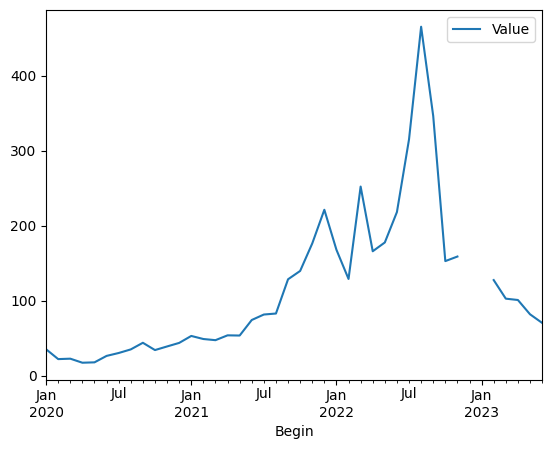

In [38]:
monthly_data.plot()

<Axes: xlabel='Begin'>

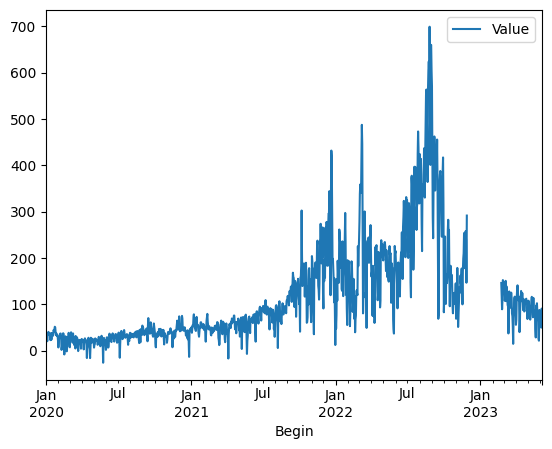

In [41]:
daily_data = df.resample('D').mean()

daily_data.plot()

In [61]:
date_range = pd.date_range(start='2020-01-01', end='2023-06-06', freq='H')

# Identify missing dates
missing_dates = set(date_range) - set(df.index)

# Print the missing dates
print("Missing Dates:")
print(sorted(missing_dates))

Missing Dates:
[Timestamp('2020-03-29 02:00:00', freq='H'), Timestamp('2021-03-28 02:00:00', freq='H'), Timestamp('2022-03-27 02:00:00', freq='H'), Timestamp('2022-11-29 00:00:00', freq='H'), Timestamp('2022-11-29 01:00:00', freq='H'), Timestamp('2022-11-29 02:00:00', freq='H'), Timestamp('2022-11-29 03:00:00', freq='H'), Timestamp('2022-11-29 04:00:00', freq='H'), Timestamp('2022-11-29 05:00:00', freq='H'), Timestamp('2022-11-29 06:00:00', freq='H'), Timestamp('2022-11-29 07:00:00', freq='H'), Timestamp('2022-11-29 08:00:00', freq='H'), Timestamp('2022-11-29 09:00:00', freq='H'), Timestamp('2022-11-29 10:00:00', freq='H'), Timestamp('2022-11-29 11:00:00', freq='H'), Timestamp('2022-11-29 12:00:00', freq='H'), Timestamp('2022-11-29 13:00:00', freq='H'), Timestamp('2022-11-29 14:00:00', freq='H'), Timestamp('2022-11-29 15:00:00', freq='H'), Timestamp('2022-11-29 16:00:00', freq='H'), Timestamp('2022-11-29 17:00:00', freq='H'), Timestamp('2022-11-29 18:00:00', freq='H'), Timestamp('2022-

In [62]:
import numpy as np

missing_df = pd.DataFrame(index=sorted(missing_dates), columns=df.columns).fillna(np.nan)

# Concatenate the original DataFrame with the new DataFrame
combined_df = pd.concat([df, missing_df])

# Sort the DataFrame based on the index ("Date")
combined_df.sort_index(inplace=True)

# Display the result
print(combined_df)

                      Value
2020-01-01 00:00:00   41.88
2020-01-01 01:00:00   38.60
2020-01-01 02:00:00   36.55
2020-01-01 03:00:00   32.32
2020-01-01 04:00:00   30.85
...                     ...
2023-06-05 20:00:00  157.37
2023-06-05 21:00:00  128.40
2023-06-05 22:00:00  101.04
2023-06-05 23:00:00   88.98
2023-06-06 00:00:00   80.23

[30052 rows x 1 columns]


In [65]:
combined_df_filled = combined_df.bfill()

# Display the result
combined_df_filled.head()

,Value
2020-01-01 00:00:00,41.88
2020-01-01 01:00:00,38.60
2020-01-01 02:00:00,36.55
2020-01-01 03:00:00,32.32
2020-01-01 04:00:00,30.85


<Axes: >

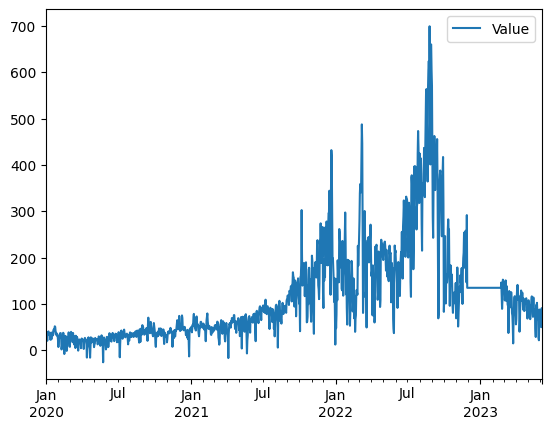

In [67]:
daily_data = combined_df_filled.resample('D').mean()

daily_data.plot()

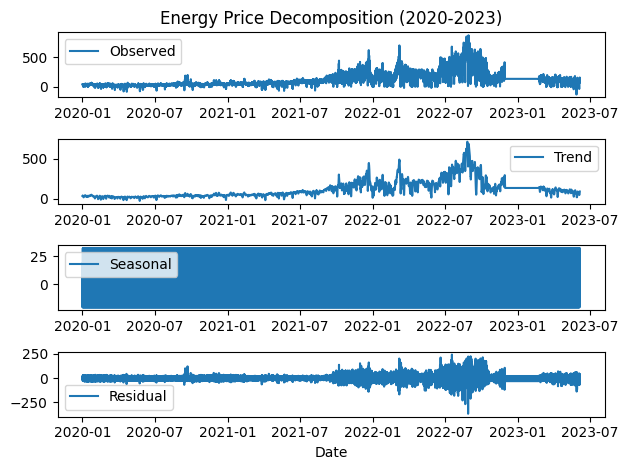

In [69]:
result = seasonal_decompose(combined_df_filled['Value'], model='additive', period=24)  # Assuming hourly data with a daily seasonality

plt.subplot(4, 1, 1)
plt.plot(combined_df_filled.index, result.observed, label='Observed')
plt.legend()
plt.title('Energy Price Decomposition (2020-2023)')

plt.subplot(4, 1, 2)
plt.plot(combined_df_filled.index, result.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(combined_df_filled.index, result.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(combined_df_filled.index, result.resid, label='Residual')
plt.legend()

plt.xlabel('Date')
plt.tight_layout()
plt.show()

In [70]:
def season_calc(month):
    """adding season based on the data on SDGE's site -> https://www.sdge.com/whenmatters#how-it-works; 
       months from June to October are denoted as 'summer' and months from November to May as 'winter'. """
    if month in [6,7,8,9,10]:
        return "summer"
    else:
        return "winter"

In [73]:
weekdays = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3: 'Thursday', 4: 'Friday', 5:'Saturday', 6:'Sunday'}
combined_df_filled['year'] = combined_df_filled.index.year
combined_df_filled['month'] = combined_df_filled.index.month
combined_df_filled['day'] = combined_df_filled.index.day
combined_df_filled['hour'] = combined_df_filled.index.hour
combined_df_filled['weekday'] = combined_df_filled.index.weekday.map(weekdays)
combined_df_filled['season'] = combined_df_filled.month.apply(season_calc)

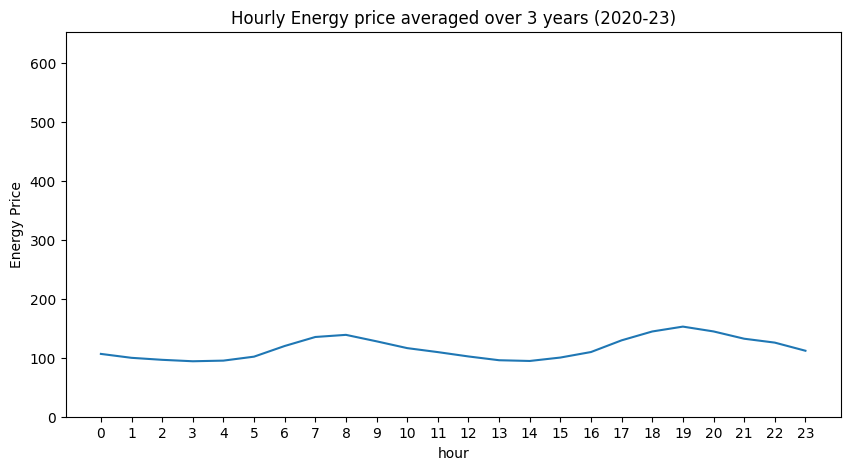

In [77]:
#Plotting average hourly load profile observed over the entire period 
combined_df_filled.groupby('hour')['Value'].mean().plot(figsize = (10,5))
_ = plt.ylabel('Energy Price')
_ = plt.ylim([0, max(combined_df_filled.groupby('hour')['Value'].mean()) + 500])
_ = plt.xticks(combined_df_filled['hour'].unique())
_ = plt.title('Hourly Energy price averaged over 3 years (2020-23)')

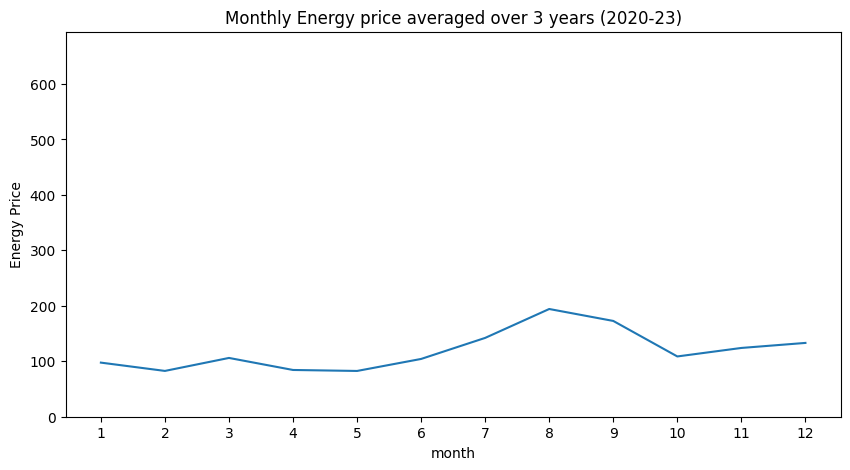

In [78]:
combined_df_filled.groupby('month')['Value'].mean().plot(figsize = (10,5))
_ = plt.ylabel('Energy Price')
_ = plt.ylim([0, max(combined_df_filled.groupby('month')['Value'].mean()) + 500])
_ = plt.xticks(combined_df_filled['month'].unique())
_ = plt.title('Monthly Energy price averaged over 3 years (2020-23)')

In [79]:
hour_weekday = combined_df_filled.pivot_table(values='Value', index='hour', columns = 'weekday', aggfunc = 'mean')

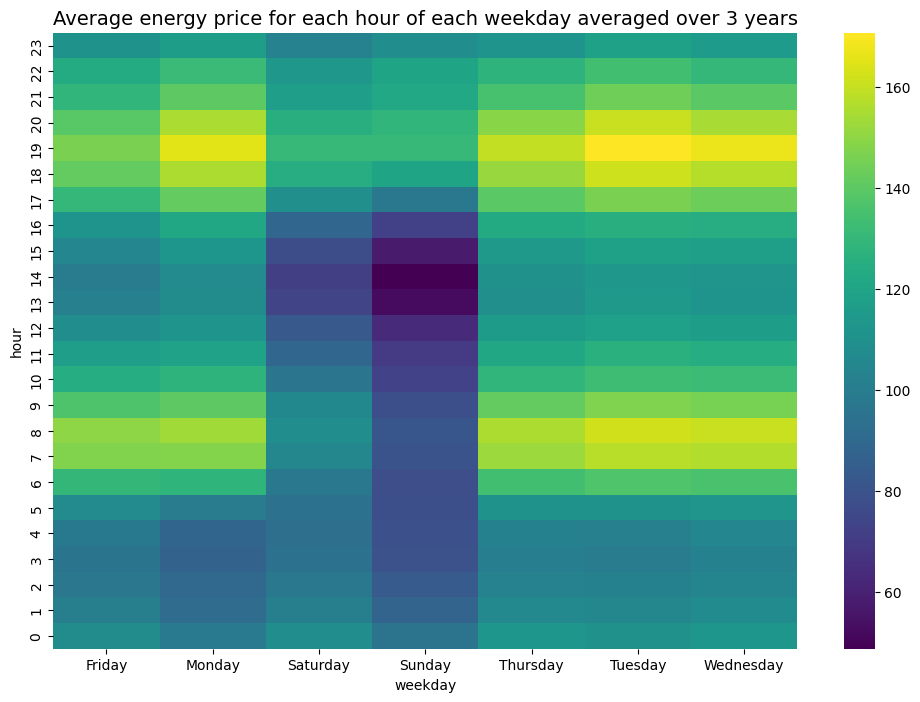

In [81]:
import seaborn as sns

_ = plt.figure(figsize=(12, 8))
ax = sns.heatmap(hour_weekday.sort_index(ascending = False), cmap='viridis')
#_ = plt.title('Average energy consumption in MWH for each hour of each weekday over the entire period')
_ = ax.set_title("Average energy price for each hour of each weekday averaged over 3 years", fontsize = 14)

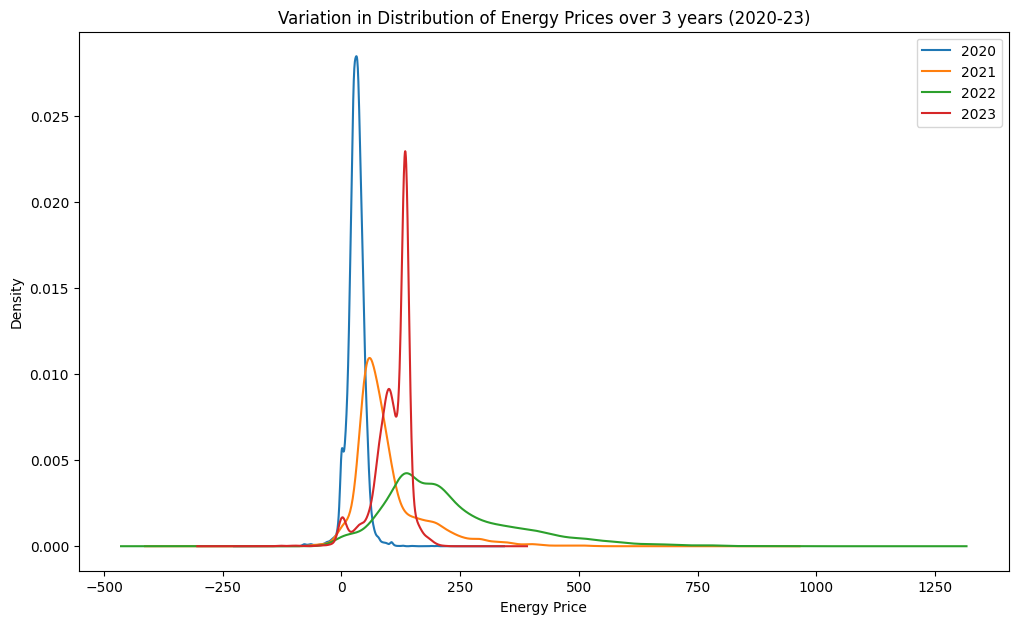

In [82]:
for year in combined_df_filled['year'].unique():
    combined_df_filled[combined_df_filled['year'] == year]['Value'].plot(kind='density', figsize = (12,7), legend = True, label = year)
_ = plt.xlabel('Energy Price')
_ = plt.title('Variation in Distribution of Energy Prices over 3 years (2020-23)')

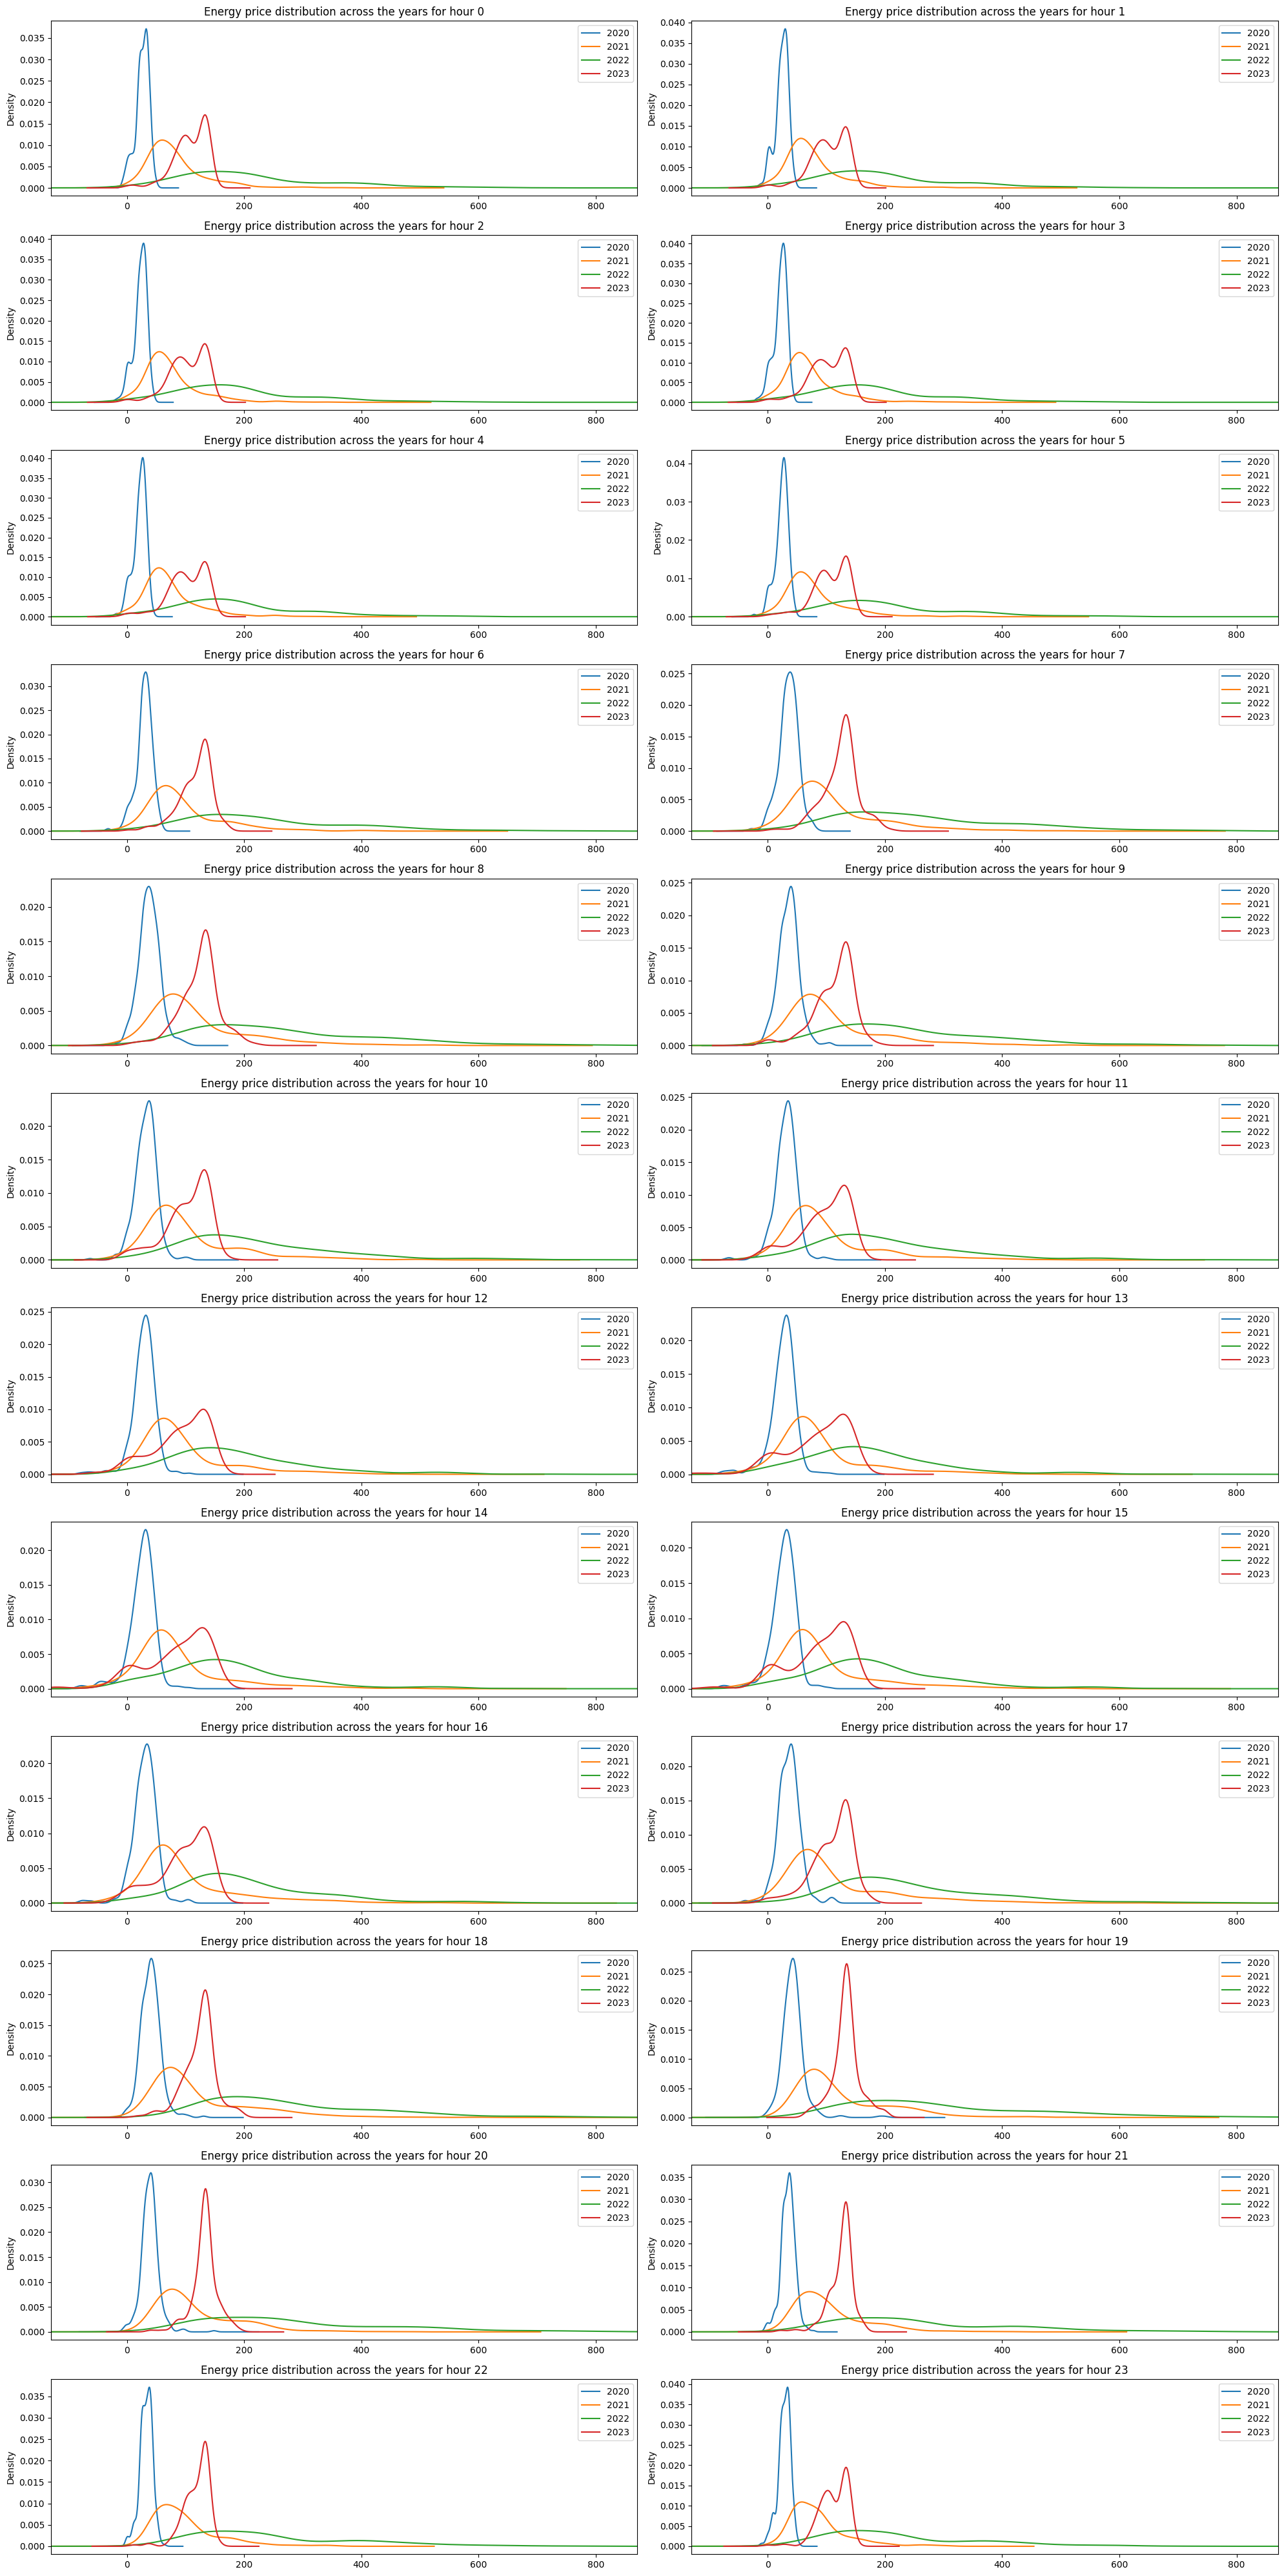

In [87]:
f = plt.figure(figsize = (20,40))
peak_hours = np.arange(0,24) 
for i, hour in enumerate(peak_hours):
    ax = f.add_subplot(12,2,i+1)
    for j, year in enumerate(combined_df_filled['year'].unique()):
        combined_df_filled[(combined_df_filled['year'] == year) & (combined_df_filled['hour'] == hour)]['Value'].\
                                plot(kind='density',  sharey=False, legend=True, label= year)# ,\
                                #c = color_names[j])
    plt.title('Energy price distribution across the years for hour '+str(hour))
    plt.xlim(np.min(combined_df_filled.Value.values), np.max(combined_df_filled.Value.values))
plt.tight_layout()

In [95]:
combined_df_filled.head()

,Value,year,month,day,hour,weekday,season
2020-01-01 00:00:00,41.88,2020,1,1,0,Wednesday,winter
2020-01-01 01:00:00,38.60,2020,1,1,1,Wednesday,winter
2020-01-01 02:00:00,36.55,2020,1,1,2,Wednesday,winter
2020-01-01 03:00:00,32.32,2020,1,1,3,Wednesday,winter
2020-01-01 04:00:00,30.85,2020,1,1,4,Wednesday,winter


In [96]:
combined_df_filled = combined_df_filled.drop(columns=["year", "month", "hour", "day", "weekday", "season"])

c:\Users\chait\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chait\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chait\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


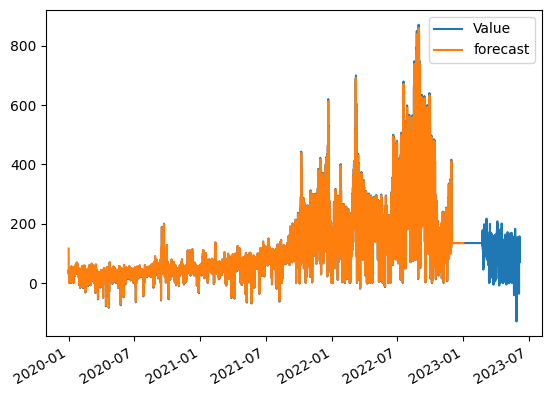

In [100]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

# combined_df_filled = combined_df_filled.astype(float)

# # Check for missing values and remove if any
# combined_df_filled = combined_df_filled.dropna()

# # Convert index to datetime if not already
# combined_df_filled.index = pd.to_datetime(combined_df_filled.index)

mod = ARIMA(combined_df_filled["Value"], order=(1,0,0))
res = mod.fit()

# Plot the data and the forecast
fig, ax = plt.subplots()
combined_df_filled.plot(ax=ax)
plot_predict(res, start=0, end='2023', alpha=None, ax=ax)
plt.show()